In [1]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
# read in CSV file
data = pd.read_csv("C:/Users/rahjo/Desktop/Test.csv")#Change to your path

# remove non-DNA characters from sequence column
data['sequence'] = data['sequence'].apply(lambda x: re.sub("[^ATCG]", "", x))

# extract first 10 oligonucleotide of each sequence, reverse and concatenate to the end
data['reverse'] = data['sequence'].apply(lambda x: x[:10][::-1])
data['sequence'] = data['sequence'] + data['reverse']

In [3]:
print(data.head())

          Name                                           sequence     reverse
0   Circ-FOXO3  GCGGCGGCGGCGGCGCCCGGGAGCCGGAGCCTTCGCGGCGTCCACG...  GGCGGCGGCG
1     COVID-19  CTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAA...  GTTTGTTATC
2  mmu-mir-295  GGTGAGACTCAAATGTGGGGCACACTTCGGACTGTACATAGAAAGT...  CTCAGAGTGG


#Viruses. Run this block or the next one.

The first argument of the qblast function specifies the type of BLAST search to perform. Here are some other options you can use instead of "blastn":

"blastp": Protein vs Protein BLAST
"blastx": Translated query Protein vs nucleotide BLAST
"tblastn": Protein vs Translated nucleotide BLAST
"tblastx": Translated query Protein vs Translated nucleotide BLAST

The second argument of the qblast function specifies the database to search against. Here are some other options you can use instead of "nt":

"nr": Non-redundant protein sequence database
"refseq_rna": RefSeq RNA sequences
"refseq_genomic": RefSeq genomic sequences
"pdbaa": Protein Data Bank (PDB) amino acid sequences
"env_nr": Non-redundant Environmental samples database

Yes, you can restrict your BLAST search to a specific organism or taxonomic group by using the entrez_query parameter of the qblast function.

For example, to restrict your search to the mouse genome, you can add the following argument to your qblast function:

makefile
Copy code
entrez_query="Mus musculus [Organism]"
This will limit your search results to sequences from the organism Mus musculus (mouse).

You can also use other types of queries to limit your search results, such as taxonomic IDs or keywords. For example, the following query would limit your search to sequences from the family Canidae:

makefile
Copy code
entrez_query="Canidae [Organism]"
You can find more information on constructing queries for NCBI searches in the NCBI Entrez Query Syntax documentation.

To restrict your BLAST search to both mouse and microRNAs, you can combine the organism and sequence type information in the entrez_query parameter of the qblast function using the boolean operator "AND".

Here's an example query that would limit your search to microRNA sequences from the mouse genome:

css
Copy code
entrez_query="Mus musculus [Organism] AND microRNA [Sequence Type]"

Yes, you can restrict your BLAST search to all viruses by using the entrez_query parameter of the qblast function to specify a taxonomic group.

To limit your search to all viruses, you can use the NCBI taxonomic identifier for viruses, which is 10239. Here's an example query that would limit your search to all viral sequences:

makefile
Copy code
entrez_query="viruses [Organism]"
This query will return all sequences from the NCBI nucleotide database that are classified as being from a virus.

Note that some sequences may be annotated as being from multiple organisms, or may not have an organism specified at all. In these cases, the entrez_query parameter may not be sufficient to completely restrict your search to a specific organism or taxonomic group. It is always a good idea to carefully review your search results to ensure that they are relevant to your research question.

In [10]:

# ref_viruses
# Define a function to perform the BLAST search and extract the results
def perform_blast(sequence):
    result_handle = NCBIWWW.qblast("blastn", "nt", sequence, expect=10, megablast=False, entrez_query="viruses [Organism]")
    blast_records = NCBIXML.parse(result_handle)
    hitIds = []
    hitLengths = []
    hitPercIdentities = []
    hitEvalues = []
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            hitIds.append(alignment.hit_id)
            hitLengths.append(alignment.length)
            hitPercIdentities.append(alignment.hsps[0].identities/alignment.length)
            hitEvalues.append(alignment.hsps[0].expect)
    seqResults = pd.DataFrame({'hitId':hitIds, 'hitLength':hitLengths, 'hitPercIdentity':hitPercIdentities, 'hitEvalue':hitEvalues})
    seqResults['QuerySeqName'] = data.loc[data['sequence'] == sequence, 'Name'].iloc[0]
    return seqResults


#This code additionally retrieve aligned sequences

In [21]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Define a function to perform the BLAST search and extract the results
def perform_blast(sequence):
    result_handle = NCBIWWW.qblast("blastn", "nt", sequence, expect=10, megablast=False, entrez_query="viruses [Organism]")
    blast_records = NCBIXML.parse(result_handle)
    hitIds = []
    hitLengths = []
    hitPercIdentities = []
    hitEvalues = []
    alignedSeqs = []
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            hitIds.append(alignment.hit_id)
            hitLengths.append(alignment.length)
            hitPercIdentities.append(alignment.hsps[0].identities/alignment.length)
            hitEvalues.append(alignment.hsps[0].expect)
            # extract aligned sequences
            aligned_seqs = []
            for hsp in alignment.hsps:
                seq_record = SeqRecord(Seq(hsp.sbjct), id=alignment.hit_id)
                aligned_seqs.append(seq_record)
            alignedSeqs.append(aligned_seqs)
    seqResults = pd.DataFrame({'hitId':hitIds, 'hitLength':hitLengths, 'hitPercIdentity':hitPercIdentities, 'hitEvalue':hitEvalues, 'alignedSeq':alignedSeqs})
    seqResults['QuerySeqName'] = data.loc[data['sequence'] == sequence, 'Name'].iloc[0]
    return seqResults

#Mouse mirRNAs

In [4]:
# Import necessary libraries
from Bio.Blast import NCBIXML
from Bio.Blast import NCBIWWW

# Define a function to perform the BLAST search and extract the results
def perform_blast(sequence):
    result_handle = NCBIWWW.qblast("blastn", "nt", sequence, expect=10, megablast=False, entrez_query="Mus musculus [Organism] AND microRNA [Sequence Type]")
    blast_records = NCBIXML.parse(result_handle)
    hitIds = []
    hitLengths = []
    hitPercIdentities = []
    hitEvalues = []
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            hitIds.append(alignment.hit_id)
            hitLengths.append(alignment.length)
            hitPercIdentities.append(alignment.hsps[0].identities/alignment.length)
            hitEvalues.append(alignment.hsps[0].expect)
    seqResults = pd.DataFrame({'hitId':hitIds, 'hitLength':hitLengths, 'hitPercIdentity':hitPercIdentities, 'hitEvalue':hitEvalues})
    seqResults['QuerySeqName'] = data.loc[data['sequence'] == sequence, 'Name'].iloc[0]
    return seqResults

In [5]:
# Use apply to apply the function to each sequence in the data frame
#results_list = data['sequence'].apply(perform_blast)
results_list = [perform_blast(seq) for seq in data['sequence']]

In [6]:
# Combine the results into a single data frame
results = pd.concat(results_list)

# Save the DataFrame as a CSV file
results.to_csv('C:/Users/rahjo/Desktop/result.csv', index=False)#Change to your path

# Split the values in Column1 into three separate columns
results[['Col1','Col2', 'Col3', 'ref']] = results['hitId'].str.split('|', n=3, expand=True)

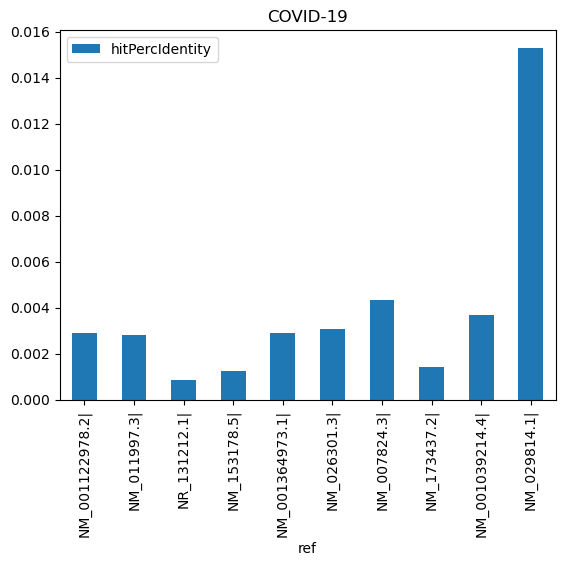

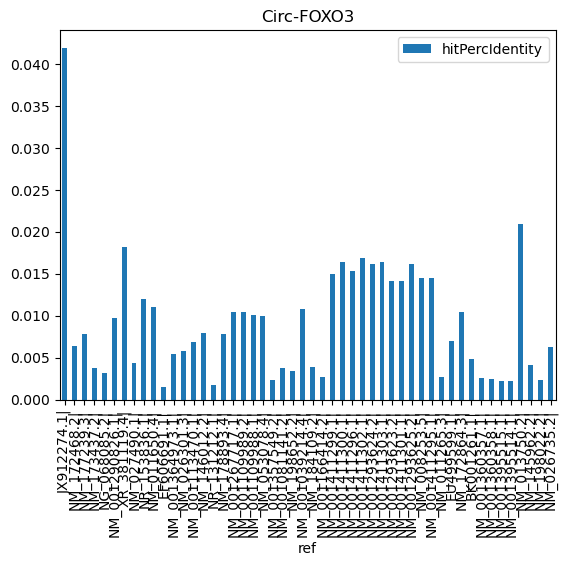

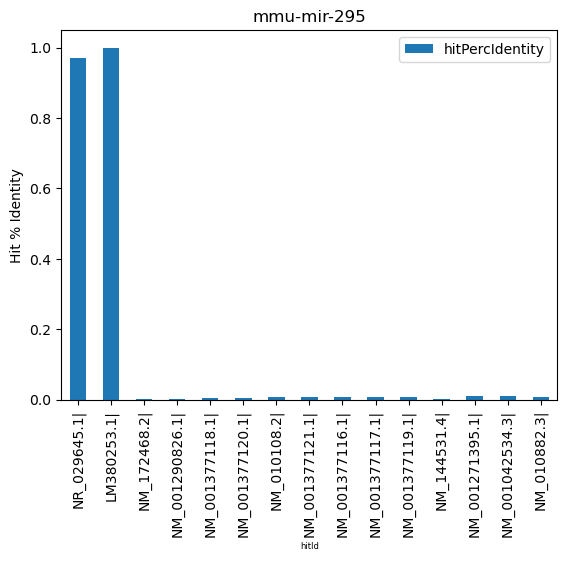

In [7]:
# Create a bar chart for each sequence using groupby
results.groupby('QuerySeqName').apply(lambda x: x.plot.bar(x='ref', y='hitPercIdentity', title=x.name))
ax = plt.gca()
ax.set_xlabel('hitId', fontsize=6)
ax.set_ylabel('Hit % Identity', fontsize=10)
#ax.set_title(x.name, fontsize=12)
# Show the charts
plt.show()

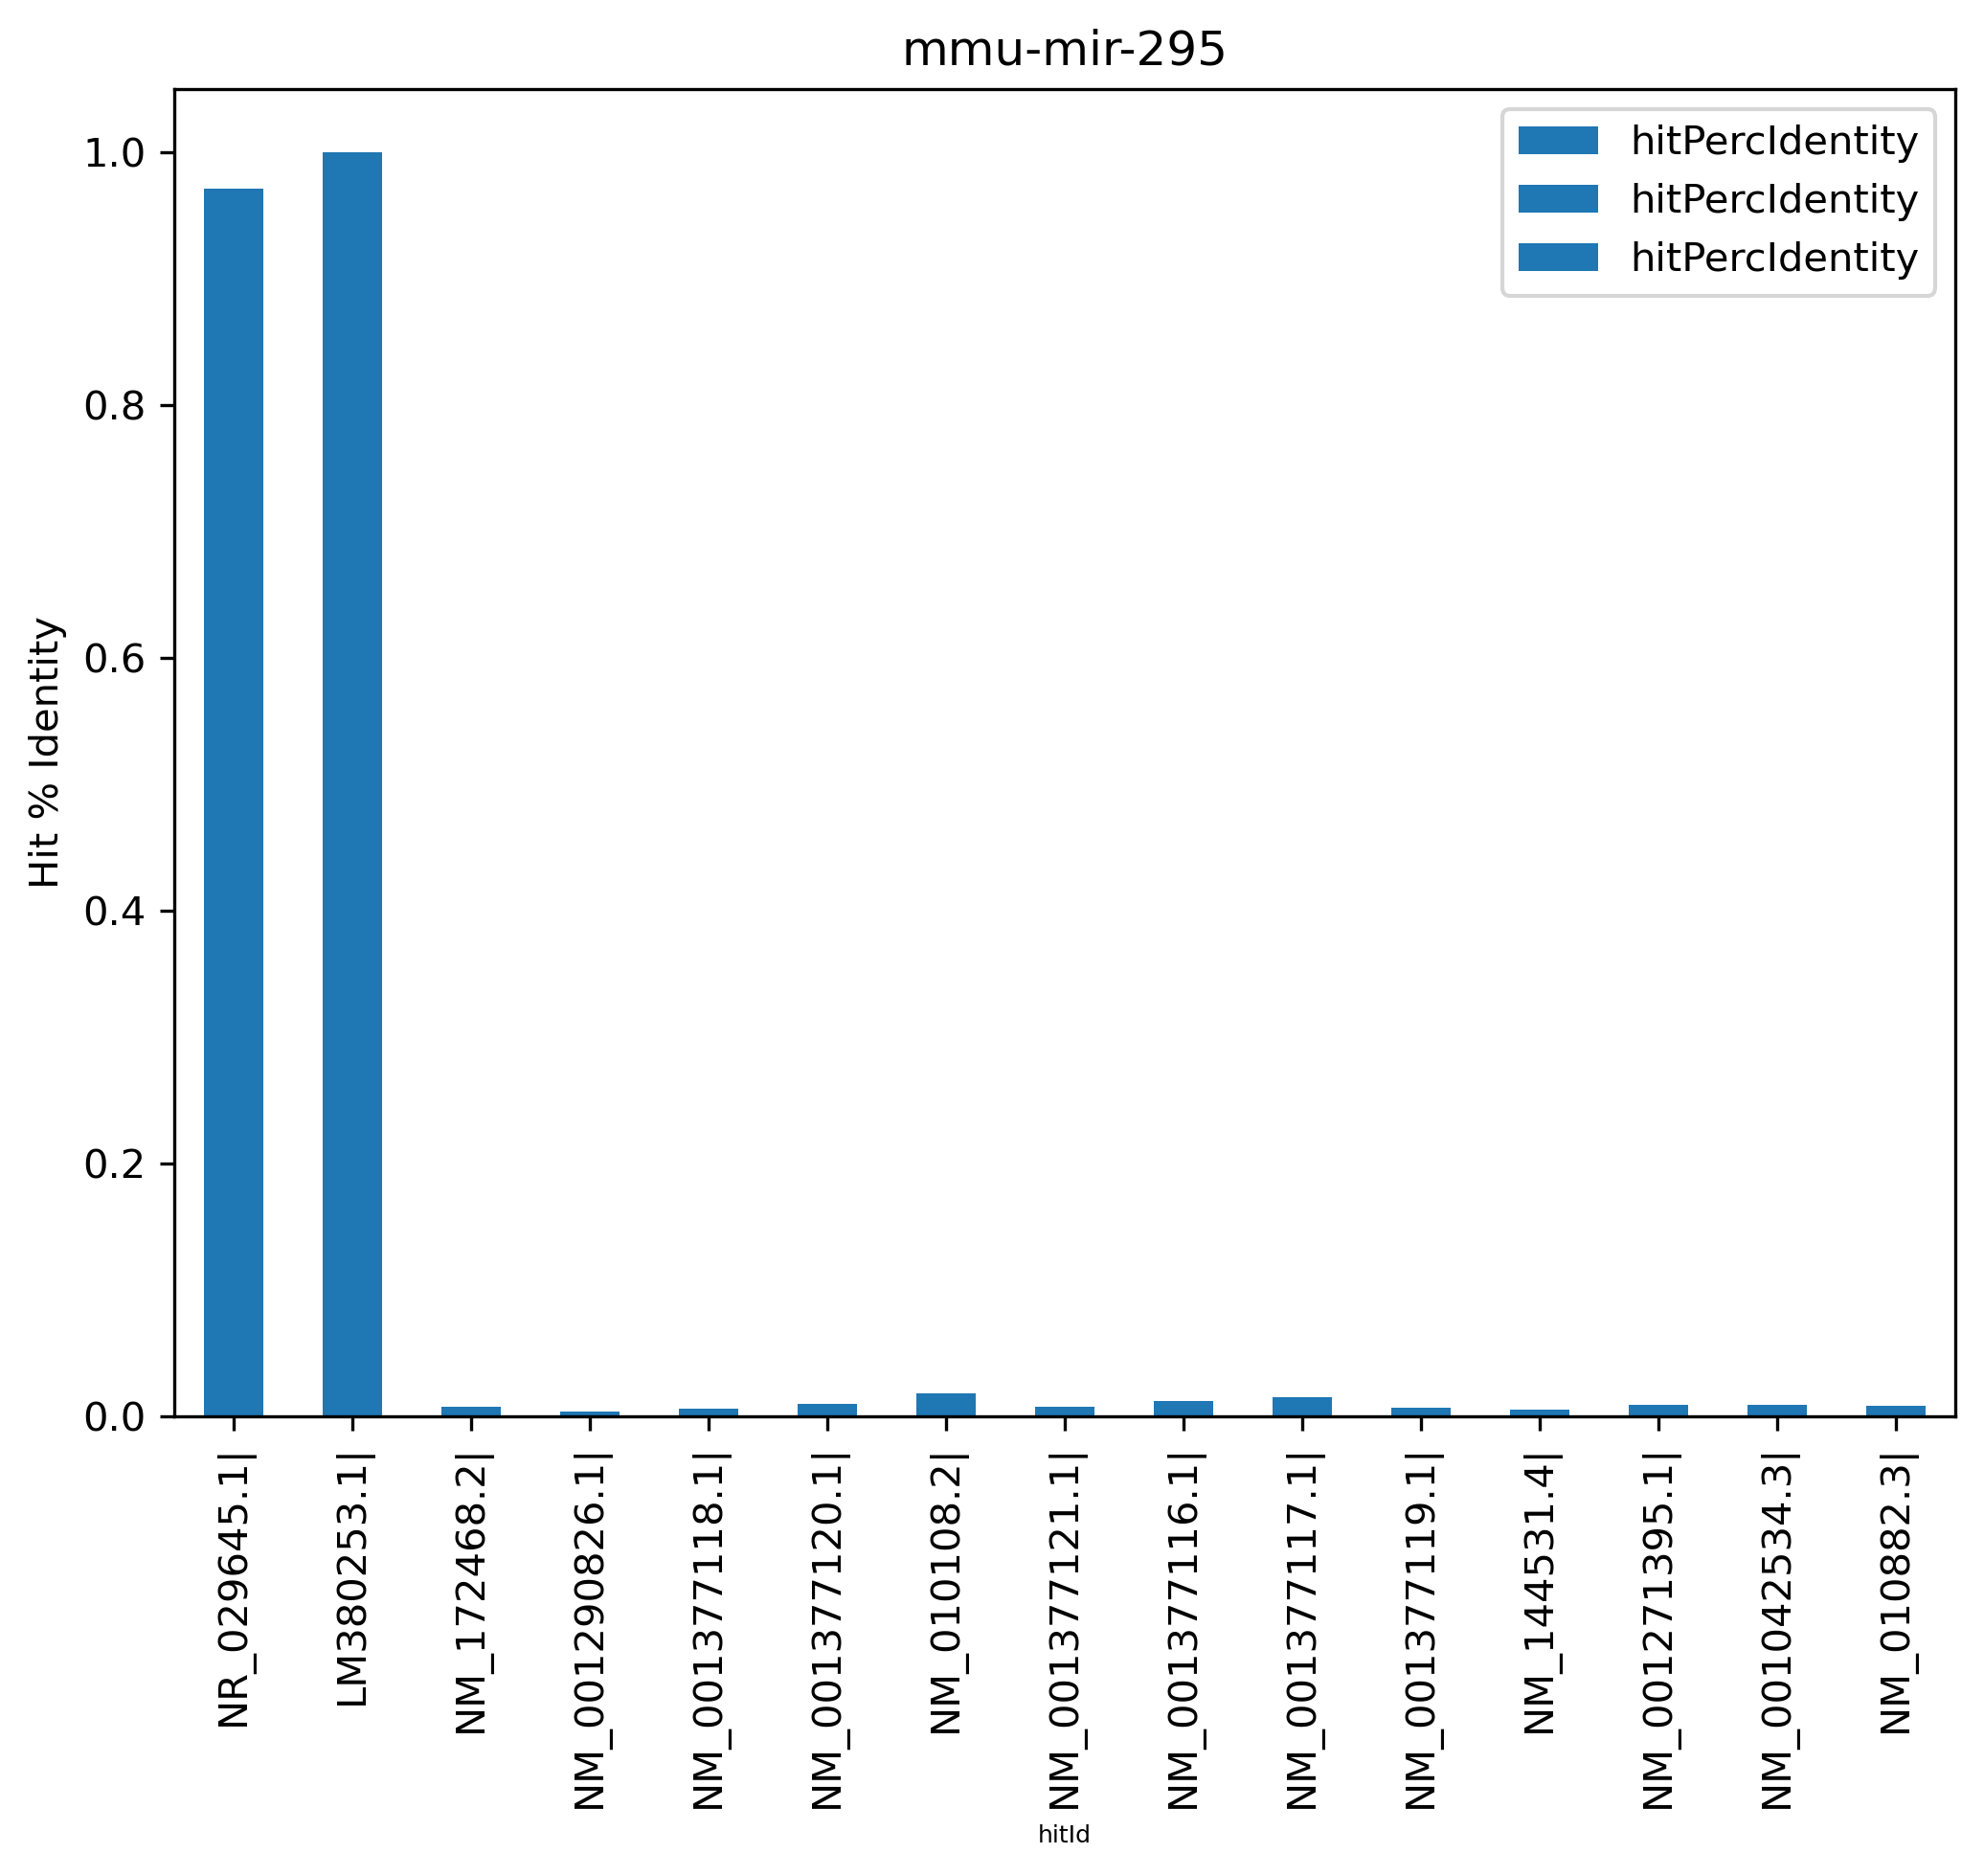

In [8]:
import os
import matplotlib.pyplot as plt

# Define the dpi size and save path
dpi = 300
save_path = os.path.join(os.getcwd(), 'C:/Users/rahjo/Desktop/')

# Create the save path directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

# Group the results by query sequence name and plot a bar chart for each group
for name, group in results.groupby('QuerySeqName'):
    group.plot.bar(x='ref', y='hitPercIdentity', title=name, ax=ax)
    
    # Set the x and y axis labels
    ax.set_xlabel('hitId', fontsize=6)
    ax.set_ylabel('Hit % Identity', fontsize=10)
    
    # Set the title
    ax.set_title(name, fontsize=12)
    
    # Save the figure in the desired format and location
    fig.savefig(os.path.join(save_path, f"{name}.png"), dpi=dpi)

# Show the charts
plt.show()


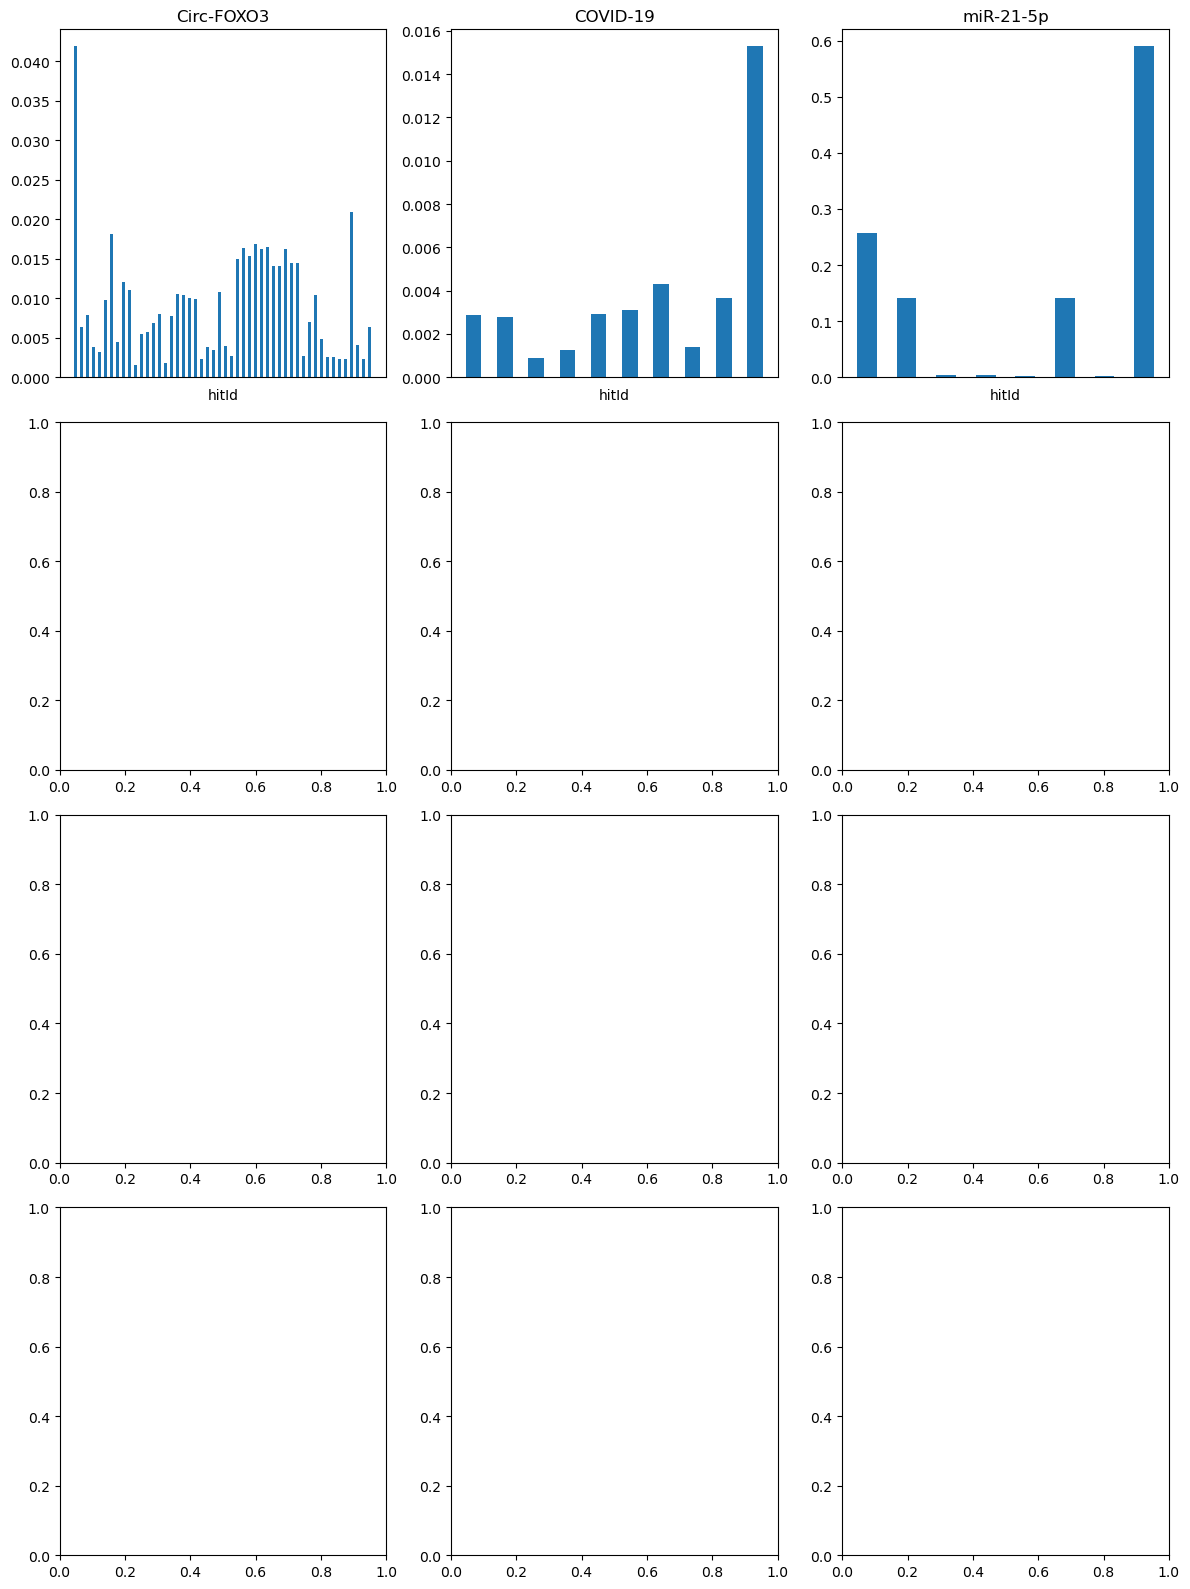

In [12]:
import matplotlib.pyplot as plt

# Determine the number of rows and columns needed for the bar charts
# Change nrows and ncols based on your output images
nrows = 4
ncols = 3

# Create a figure with the specified number of rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 16))

# Loop through each unique query sequence name
for i, name in enumerate(results['QuerySeqName'].unique()):
    # Calculate the row and column index for this query sequence
    row_idx = i // ncols
    col_idx = i % ncols
    
    # Select data for this query sequence
    data = results.loc[results['QuerySeqName'] == name]
    
    # Add the bar chart for this query sequence to the corresponding subplot
    data.plot.bar(x='hitId', y='hitPercIdentity', title=name, ax=axes[row_idx, col_idx])
    
    # Hide the x-axis ticks and labels for all subplots
    axes[row_idx, col_idx].set_xticks([])
    axes[row_idx, col_idx].set_xticklabels([])
    
    # Remove the x-axis legend
    axes[row_idx, col_idx].legend().remove()
    
    # Adjust the layout of the subplot
    axes[row_idx, col_idx].autoscale(enable=True, axis='both', tight=True)
    axes[row_idx, col_idx].margins(0.05)
    
# Adjust the layout of the subplots
fig.tight_layout()

# Show the figure
plt.show()
